### Purpose

Previously we've been using specific timepoints to get the directional vector for a particular gaze of a product. 

The better solution here is to detect the multiple ranges of times at which there are different generating distributions of the data observed (in our case, pitch/yaw/roll angles).

### Import data

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

DATA_DIR = 'notebook_data'
VIDEOS_DIR = 'videos'

ORIGINAL_VIDEO_FILENAME = 'Camera 1 - Vendlytics Prototype.mp4'
FACE_DETECTION_VIDEO_FILENAME = 'output-_local.avi'
GAZE_DETECTION_VIDEO_FILENAME = 'output-_local_1.avi'

FACE_BBOXES_FILENAME = 'frame_to_bbox.txt'
GAZE_ANGLES_FILENAME = 'frame_to_gaze.txt'

ORIGINAL_VIDEO_PATH = os.path.join(DATA_DIR, VIDEOS_DIR, ORIGINAL_VIDEO_FILENAME)
FACE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VIDEOS_DIR, FACE_DETECTION_VIDEO_FILENAME)
GAZE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VIDEOS_DIR, GAZE_DETECTION_VIDEO_FILENAME)
FACE_BBOXES_PATH = os.path.join(DATA_DIR, FACE_BBOXES_FILENAME)
GAZE_ANGLES_PATH = os.path.join(DATA_DIR, GAZE_ANGLES_FILENAME)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


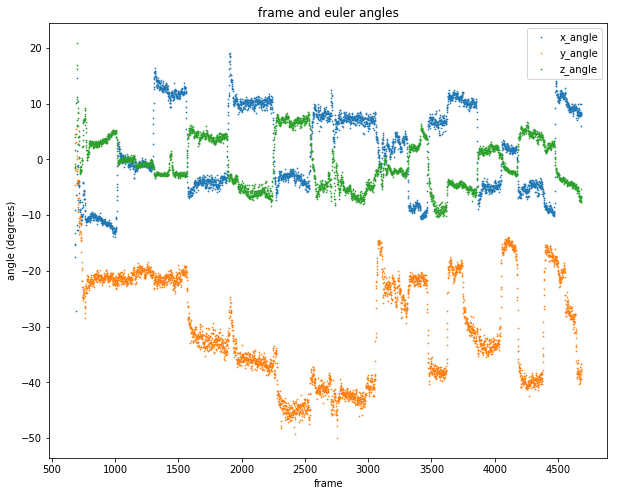

In [2]:
bbox_df = pd.read_csv(FACE_BBOXES_PATH, delimiter=' ', header=None)
bbox_df.columns = ['frame_number', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence_score']

gaze_df = pd.read_csv(GAZE_ANGLES_PATH, delimiter=' ', header=None)
gaze_df.columns = ['frame_number', 'x_angle', 'y_angle', 'z_angle']

MARKER_SIZE = 0.5
FRAME_LIMIT = 4000

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

x = gaze_df.T.loc['frame_number'][:FRAME_LIMIT]
ax1.scatter(x, gaze_df.T.loc['x_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # x angle
ax1.scatter(x, gaze_df.T.loc['y_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # y angle
ax1.scatter(x, gaze_df.T.loc['z_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # z angle

plt.title("frame and euler angles")
plt.xlabel("frame")
plt.ylabel("angle (degrees)")

plt.legend(["x_angle", "y_angle", "z_angle"])
fig.show()

In [75]:
# times (s) when ashton was looking at each of 7 products
TIME_MARKERS_SEC = [27, 34, 44, 53, 66, 77, 87, 97]

# we know video is 30 fps, so 30 * TIME_MARKERS_SEC[i] 
# (where i is single product) gives us frame to use angle from
TIME_MARKERS_FRAMES = [(30 * i) for i in TIME_MARKERS_SEC]

print(TIME_MARKERS_FRAMES)

[810, 1020, 1320, 1590, 1980, 2310, 2610, 2910]


In [83]:
def frame_to_label(frame):
    """
    Take as input some frame number and map it to a product
    
    810  - 1020 : 0
    1020 - 1320 : 1
    1320 - 1590 : 2
    1590 - 1980 : 3
    1980 - 2310 : 4
    2310 - 2610 : 5
    2610 - 2910 : 6
    other     : 7
    """
    
    if 810 < frame <= 1020: return 0
    elif 1020 < frame <= 1320: return 1
    elif 1320 < frame <= 1590: return 2
    elif 1590 < frame <= 1980: return 3
    elif 1980 < frame <= 2310: return 4
    elif 2310 < frame <= 2610: return 5
    elif 2610 < frame <= 2910: return 6
    else: return 7

### VAE setup

Gaze direction vector during one product viewing is probably a Gaussian.

In [4]:
import os

import numpy as np
import torch
import torch.utils.data
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [5]:
import torchvision.transforms as transforms

In [224]:
class EulerAnglesDataset(torch.utils.data.Dataset):
    """Euler Angles dataset."""

    def __init__(self, csv_file=GAZE_ANGLES_PATH, train=True, transform=None):
        STOP_LIMIT = 2910
        TRAIN_RATIO = 0.8
        
        df = pd.read_csv(csv_file, delimiter=' ', header=None)[:STOP_LIMIT]
        df.columns = ['frame_number', 'x_angle', 'y_angle', 'z_angle']
        self.transform = transform
        
        mask = np.random.rand(len(df)) < TRAIN_RATIO
        
        if train:
            self.euler_angles_frame = df[mask]
        else:
            self.euler_angles_frame = df[~mask]
    
    def __getitem__(self, idx):
        label = frame_to_label(self.euler_angles_frame.iloc[idx, 0])
        euler_angles = self.euler_angles_frame.iloc[idx, 1:].as_matrix()
        return euler_angles, label
    
    def __len__(self):
        return len(self.euler_angles_frame)

In [91]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [92]:
GAZE_ANGLES_PATH

'notebook_data/frame_to_gaze.txt'

In [95]:
def setup_data_loaders(batch_size=24, use_cuda=False):
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0, 0, 0), (1, 1, 1))
    ])
    train_set = EulerAnglesDataset(csv_file=GAZE_ANGLES_PATH, train=True, transform=trans)
    test_set = EulerAnglesDataset(csv_file=GAZE_ANGLES_PATH, train=False, transform=trans)
    
    kwargs={'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

$Softplus(x) = \frac{1}{\beta} * log(1 + exp(\beta * x))$

In PyTorch $\beta$ defaults to $1$.

In [ ]:
INPUT_DIM = 3  # 3 angles

# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(INPUT_DIM, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        self.softplus = nn.Softplus()

    def forward(self, x):
        # x = x.reshape(-1, INPUT_DIM)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

# observation likelihood p(x|z)
class Decoder(nn.Module):
    
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, INPUT_DIM)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img


class VAE(nn.Module):
    
    def __init__(self, z_dim=10, hidden_dim=200, use_cuda=False):
        super(VAE, self).__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
#             print(loc_img)
            
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 3))
            # return the loc so we can visualize it later
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [ ]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

def train(svi, train_loader, use_cuda=False):
    epoch_loss = 0.
    
    for x, _ in train_loader:
        epoch_loss += svi.step(x.float())

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    test_loss = 0.
    for x, _ in test_loader:
        test_loss += svi.evaluate_loss(x.float())
    
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [ ]:
train_loader, test_loader = setup_data_loaders(batch_size=48, use_cuda=False)

In [ ]:
smoke_test = False

In [ ]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

In [223]:
USE_CUDA = False
LEARNING_RATE = 1.0e-5
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []

# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    writer.add_scalar('data/epoch_loss_1', total_epoch_loss_train, epoch)
    
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 000]  average training loss: 418835231364.4354


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 000] average test loss: 388621450333.6128


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 001]  average training loss: 357833243955.7491


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 002]  average training loss: 248372023780.3531


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 003]  average training loss: 238804891771.9583


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 004]  average training loss: 164565488781.8526


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 005]  average training loss: 140743194982.0147


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 005] average test loss: 114693390472.6863


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 006]  average training loss: 117824790893.1836


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 007]  average training loss: 90405134762.2289


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 008]  average training loss: 95082568986.8342


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 009]  average training loss: 69059968593.1064


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 010]  average training loss: 71494089080.3254


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 010] average test loss: 50014638087.7762


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 011]  average training loss: 54411243474.3539


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 012]  average training loss: 51711848923.5476


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 013]  average training loss: 43571241837.4147


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 014]  average training loss: 49623333245.5995


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 015]  average training loss: 42916585126.3826


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 015] average test loss: 34492172951.3240


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 016]  average training loss: 31826524972.6011


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 017]  average training loss: 31055797976.7250


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 018]  average training loss: 30249715529.8150


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 019]  average training loss: 27383136925.0215


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 020]  average training loss: 25380334485.1735


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 020] average test loss: 27035735816.9909


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 021]  average training loss: 22095529411.3841


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 022]  average training loss: 21099244471.3021


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 023]  average training loss: 22501614158.7559


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 024]  average training loss: 22340405710.8014


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 025]  average training loss: 16881193821.3469


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 025] average test loss: 14708555497.1405


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 026]  average training loss: 16812736293.4698


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 027]  average training loss: 17622166290.0005


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 028]  average training loss: 16116709064.0781


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 029]  average training loss: 14998322680.5151


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 030]  average training loss: 14747287119.2007


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 030] average test loss: 11594492223.6114


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 031]  average training loss: 15751497408.5223


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 032]  average training loss: 11022263091.3580


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 033]  average training loss: 13562352345.5789


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 034]  average training loss: 10933821741.0773


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 035]  average training loss: 10801977983.5004


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 035] average test loss: 10701231835.8145


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 036]  average training loss: 9075871260.5711


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 037]  average training loss: 10605170570.1261


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 038]  average training loss: 8441077389.8176


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 039]  average training loss: 9269657732.5295


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 040]  average training loss: 9060549975.1795


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 040] average test loss: 6988503581.4674


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 041]  average training loss: 8447168537.4329


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 042]  average training loss: 7312245420.7132


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 043]  average training loss: 6989243045.7445


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 044]  average training loss: 7452658430.1102


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 045]  average training loss: 7748987692.6725


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 045] average test loss: 6044506792.4339


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 046]  average training loss: 5689606496.9394


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 047]  average training loss: 6501660345.9656


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 048]  average training loss: 5532726483.7022


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 049]  average training loss: 6222373366.4065


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 050]  average training loss: 6605611007.0776


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 050] average test loss: 5452232730.3599


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 051]  average training loss: 5717003666.0723


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 052]  average training loss: 4758297222.5844


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 053]  average training loss: 4566540922.4079


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 054]  average training loss: 5060446176.4001


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 055]  average training loss: 4715600379.3325


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 055] average test loss: 4305907373.0858


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 056]  average training loss: 5147336410.1365


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 057]  average training loss: 4602169198.0184


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 058]  average training loss: 4267909507.6255


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 059]  average training loss: 3445103996.8870


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 060]  average training loss: 3875694891.6284


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 060] average test loss: 3864351483.6175


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 061]  average training loss: 3738536072.7265


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 062]  average training loss: 3734843096.6645


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 063]  average training loss: 3888838536.6014


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 064]  average training loss: 2900311154.7291


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 065]  average training loss: 3342874151.2032


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 065] average test loss: 2314239578.7678


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 066]  average training loss: 3233377174.5362


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 067]  average training loss: 3583518908.1023


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 068]  average training loss: 2592163829.1311


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 069]  average training loss: 2832044367.1039


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 070]  average training loss: 2977491728.5607


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 070] average test loss: 2847724679.4934


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 071]  average training loss: 2793377995.8309


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 072]  average training loss: 2394668039.1745


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 073]  average training loss: 2342951937.2269


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 074]  average training loss: 2351598835.3352


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 075]  average training loss: 2188875456.6567


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 075] average test loss: 1820157511.4168


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 076]  average training loss: 2236816090.1292


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 077]  average training loss: 2225160776.2378


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 078]  average training loss: 1989046496.4867


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 079]  average training loss: 2254651702.0783


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 080]  average training loss: 1900115958.2687


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 080] average test loss: 2081393665.1351


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 081]  average training loss: 2178745911.4025


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 082]  average training loss: 1830357798.2379


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 083]  average training loss: 1908484444.8027


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 084]  average training loss: 1891294706.4407


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 085]  average training loss: 1711599458.8768


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 085] average test loss: 1550241969.1181


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 086]  average training loss: 1691052856.8156


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 087]  average training loss: 1707591147.7705


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 088]  average training loss: 1617492845.3668


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 089]  average training loss: 1496892860.2106


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 090]  average training loss: 1963624597.5500


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 090] average test loss: 1312667021.8793


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 091]  average training loss: 1483959305.5418


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 092]  average training loss: 1186761773.8551


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 093]  average training loss: 1594145377.1247


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 094]  average training loss: 1469969804.6615


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 095]  average training loss: 1462085069.7908


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 095] average test loss: 1341270869.4640


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 096]  average training loss: 1254258307.7929


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 097]  average training loss: 1232670500.8282


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 098]  average training loss: 1153396360.9637


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[epoch 099]  average training loss: 1213724775.0119


In [225]:
def plot_tsne(z_loc, classes, name):
    import matplotlib
    matplotlib.use('Agg')
    
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.manifold import TSNE
    
    model_tsne = TSNE(n_components=2, random_state=0)
    
    z_states = z_loc.detach().cpu().numpy()
    z_embed = model_tsne.fit_transform(z_states)
    
    return z_embed
    
    classes = classes.detach().cpu().numpy()
    
    fig = plt.figure()
    for ic in range(8):
        ind_vec = np.zeros_like(classes)
        ind_vec[:] = 1
#         ind_vec[:, ic] = 1
#         ind_class = classes[:, ic] == 1
        ind_class = classes[:] == 1
        color = plt.cm.Set1(ic)
        plt.scatter(z_embed[ind_class, 0], z_embed[ind_class, 1], s=10, color=color)
        plt.title("Latent Variable T-SNE per Class")
        fig.savefig('./vae_results/'+str(name)+'_embedding_'+str(ic)+'.png')
    fig.savefig('./vae_results/'+str(name)+'_embedding.png')

In [226]:
labels = []
for i in test_loader.dataset.euler_angles_frame.iloc[:, 0].values:
    labels.append(frame_to_label(i))

In [227]:
name = 'VAE'
data = torch.from_numpy(
    test_loader.dataset.euler_angles_frame.iloc[:, 1:].values
).float()
labels = torch.from_numpy(
    np.array(labels)
)
z_loc, z_scale = vae.encoder(data)
z_embed = plot_tsne(z_loc, labels, name)

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  This is separate from the ipykernel package so we can avoid doing imports until


In [238]:
ind_vec = np.zeros_like(labels)
ind_vec[:] = 1
ind_class = labels[:] == 0

In [239]:
z_embed[ind_class, 1]

array([4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543,
       4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543,
       4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543,
       4.3286543, 4.3286543, 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 , 4.248523 ,
       4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543,
       4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543,
       4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543, 4.3286543,
       4.3286543, 4.3286543, 4.3286543, 4.3286543, 

In [147]:
ls

VAE_embedding.png    VAE_embedding_2.png  VAE_embedding_5.png
VAE_embedding_0.png  VAE_embedding_3.png  VAE_embedding_6.png
VAE_embedding_1.png  VAE_embedding_4.png  VAE_embedding_7.png
